In [2]:
import sys
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from plotbin.plot_velfield import plot_velfield
from scipy.constants import c
C = c/1000 #299792.458  # speed of light in km/s

In [3]:
class read_muse_cube(object):
    def __init__(self,filename,wave_range,z):
        """
        Adapting Cappellari PPXF MUSE example to WEAVE data
        
        """  
        hdu = pyfits.open(filename)
        head = hdu[1].header
        cube = hdu[1].data  

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        #spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = (head['CRVAL3'] + head['CD3_3']*np.arange(npix))   
        pixsize = abs(head["CD1_1"])*3600    # 0.2"

        # Only use a restricted wavelength range
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = cube[w,:,:]
        
        wave = wave[w]/(1+z)

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = 46.27319167       #C*np.diff(np.log(wave[-2:])) # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        Nz,Ny,Nx=np.shape(spectra)
        
        self.spectra = spectra
        self.nx=Nx
        self.ny=Ny
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 1.07 # to be checked: FWHM spectral resolution of WEAVE in A.

In [4]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, lam, lam_temp):
    
    print('##############################################################')
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)

    optimal_template = templates @ pp.weights
    
    return pp, optimal_template

In [6]:
lam_range_temp = [5792, 8975]   
s = read_muse_cube('./mock_red_cube.fits',lam_range_temp,0)

In [7]:
velscale=46.27319167

In [8]:
ppxf_dir = '/Users/dkakkad/miniconda3/envs/research/lib/python3.9/site-packages/ppxf'
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
FWHM_gal = None   # set this to None to skip convolutions
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [9]:
#z = 0.002964
z_og=0.0# redshift estimate from NED
vel0 =0#C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]

In [10]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0=np.arange(0,len(s.ln_lam_gal),1)
filt_badpix=np.where(np.logical_and(s.ln_lam_gal>np.log(6530),s.ln_lam_gal<np.log(6605)) |
                     np.logical_and(s.ln_lam_gal>np.log(7570),s.ln_lam_gal<np.log(7679)) |
                     np.logical_and(s.ln_lam_gal>np.log(6698),s.ln_lam_gal<np.log(6739)) |
                     np.logical_and(s.ln_lam_gal>np.log(6858),s.ln_lam_gal<np.log(6934)))
goodpixels0=np.delete(goodpixels0,filt_badpix)

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:      -254        76
chi2/DOF: 3.265e+04; DOF: 2552; degree = -1; mdegree = 4
method = capfit; Jac calls: 14; Func calls: 101; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150


SystemExit: 

/Users/dkakkad/miniconda3/envs/research/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


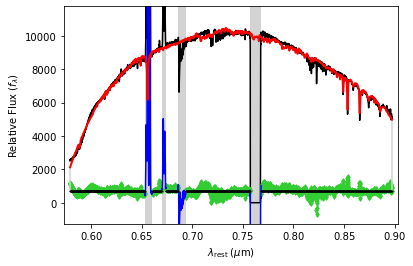

In [11]:
lam_gal = np.exp(s.ln_lam_gal)

vel_gal=np.zeros((s.ny,s.nx))
sig_gal=np.zeros((s.ny,s.nx))
raw_cube_dat=np.zeros_like(s.spectra)
stel_cont=np.zeros_like(s.spectra)

for i in range(75,76):
    for j in range(73,90):
        galaxy=s.spectra[:,j,i]
        pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, 
                                             lam_gal, miles.lam_temp)
        vel_gal[j,i],sig_gal[j,i]= pp.sol
        raw_cube_dat[:,j,i]=pp.galaxy
        stel_cont[:,j,i]=pp.bestfit
        pp.plot()
        sys.exit()

(70.0, 90.0)

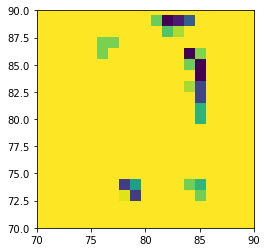

In [37]:
plt.imshow(vel_gal,origin="lower",vmin=-258,vmax=-25)
plt.xlim([70,90])
plt.ylim([70,90])